In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

rolling_period = 20

def read_system_json(algo, env, scenario, env_n, seed):
    seed = f"seed_{seed}"
    path = f"../results/json/{algo}/{env}/{scenario}/envs_{env_n}/{seed}/"
    try:
        with open(path + "metrics.json", "r") as f:
            data = json.load(f)
    except:
        print(f"Failed to read {path}")
        return None

    data = data[env][scenario][algo][seed]
    records = {}
    for key in data.keys():
        n = key.split("_")[1]
        if len(n) > 3: continue # skip abs metric
        entry = {"mean_episode_returns": data[key]["mean_episode_returns"][0]}
        records[int(n)] = entry
    df = pd.DataFrame.from_dict(records, orient="index")
    if len(df) == 0: return None
    # TODO: this method provides a lagging rolling mean, I need to change it to provide a RT mean
    df[f"rolling_20"] = df["mean_episode_returns"].rolling(20, min_periods=1, center=True).mean()
    df[f"rolling_10"] = df["mean_episode_returns"].rolling(10, min_periods=1, center=True).mean()
    
    return df

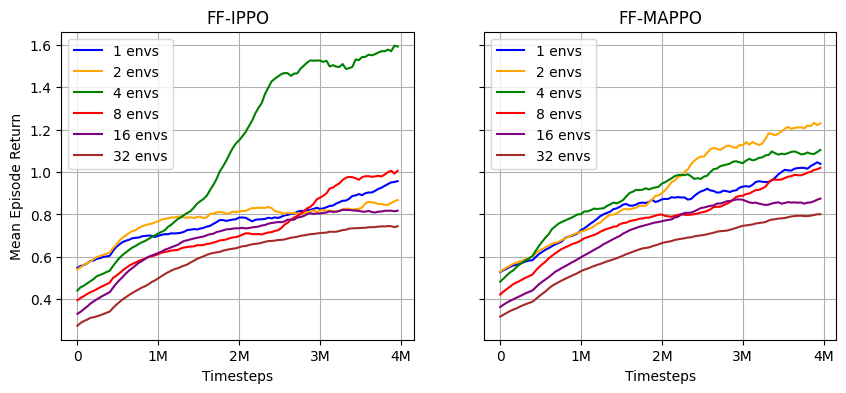

In [10]:
env = "HeuristicEnemySMAX"
scenario = "2s3z"

env_ns = [1, 2, 4, 8, 16, 32]
seeds = [42]
colors = ['blue', "orange", 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# ax = plt.gca()
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

i = 0
for env_n in env_ns:
    for seed in seeds:
        df = read_system_json("ff_ippo", env, scenario, env_n, 42)

        if df is None: continue
        
        df.plot(y="rolling_20", label=f"{env_n} envs", ax=axs[0], color=colors[i])


        df = read_system_json("ff_mappo", env, scenario, env_n, 43)
        df.plot(y="rolling_20", label=f"{env_n} envs", ax=axs[1], color=colors[i])

        i += 1


axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xticks([0, 25, 50, 75, 100], ["0", "1M", "2M", "3M", "4M"])
axs[1].set_xticks([0, 25, 50, 75, 100], ["0", "1M", "2M", "3M", "4M"])
axs[0].set_xlabel("Timesteps")
axs[1].set_xlabel("Timesteps")
axs[0].set_ylabel("Mean Episode Return")
axs[0].set_title("FF-IPPO")
axs[1].set_title("FF-MAPPO")

plt.savefig("../Images/ff_ippo_vs_ff_mappo.png")
